# Model Predictive Control (4) - Optimal Control Problems solution using the CasaDi framework

## Table of contents <a class="anchor" id="toc"></a>


### [Solving Optimal control problem using Casadi](#ThisNotebook)
[The Casadi Framework](#casadiIntro) / [Official Video Tutorial](#tuto) / [Single-Shooting vs Multiple-Shooting](#SSvsMS) /  [Back to the PVTOL example](#SS-PVTOL) / [dynamics](#dynamics-PVTOL) / [The discrete one step function](#onestep-PVTOL) / [Single-shooting Formulation of the Nonlinear Programming Problem](#formulation-PVTOL) / [Solving the Single-Shooting problem](#solving-PVTOL) / [Multiple-shooting Formulation of the Nonlinear Programming Problem](#MS-PVTOL) / [Solvin the Multiple-Shooting problem](#solvingMS-PVTOL) / [Discussion](#discussion)

In [1]:
from IPython.display import Image, IFrame
import ipywidgets as wg
import numpy as np
import matplotlib.pyplot as plt
import time

!pip install casadi

files_root = "https://www.mazenalamir.fr/MPC/"

width=800

## This Notebook<a class="anchor" id="ThisNotebook"></a>

In the previous noteboook, we showed that using the general purposes nonlinear programming solvers in order to solve the constrained open-loop optimal control problems can lead to computation times that might be too large to be compatible with repetitive solution of these problem as it is required in the MPC implementation. 

That is the reason why a dedicated solvers have been developed these last years in order to come out with NLP frameworks that might solve the underlying problem in faster way. 


One of these framework has been developed by researchers from the control system community or associated to it. This is the Casadi framework. 

>**Do not forget that as far as this series of course on Model Predictive Control is concerned, solving open-loop optimal control problem is a step toward the implementation of the MPC feedback which consists in applying the first control input in the optimal sequence of control. (please refer to the first notebook in this series for a complete reminder of the MPC control definition** 

## The Casadi Framework<a class="anchor" id="casadiIntro"></a>

Rigorously speaking, the Casadi is not a solver but a framework of problem's defintion that calls for different kinds of NLP solvers or utilitites. It goes beyong the solution of NLP problem and can be used for a range of applied mathematics problem that can be encountered in various fields of engineerging such as:

1. Integrating differential equations (ODEs) and Algebro Differential Equations (DAEs)
2. Computing sensitivities (Jacobians, Hessian) 
3. Solving optimization problems 
4. Finding zeros of nonlinear functions, 
5. and some other possibilities

For more information regarding this framework, one can visit the project's website (see below). In particular, you can visualize the tutorial video that follows. 

In [2]:
casadi_site = "https://web.casadi.org/"
display(IFrame(casadi_site, width=width, height=400))

[back to toc](#toc)

## Casadi official video Tutorial<a class="anchor" id="tuto"></a>

In [3]:
#You might need to click on the left area in order to get to the 
# total height of the cell in order to comfortably visualize the video

Introduction = "https://www.youtube.com/embed/JI-AyLv68Xs"
display(IFrame(Introduction, width=width, height=500))

[back to toc](#toc)

## Single-shooting vs Multiple-shooting<a class="anchor" id="SSvsMS"></a>

In what follows, an example of use of this framework in order to solve the same optimal control problem that has been studied in the previous notebook is proposed for completeness. Note that there is no a unique way to use casadi to implement and solve an optimal control problem. 

The solution proposed in this notebook is one possibility, you might follow the video and browse the examples section in the website to come with different ways of implementing and solving the problem. 

In partiuclar, there is two main possibilities that are fundamentally different which are:

1. The single-shooting implementation 
2. The multiple-shooting implementation



These two options correspond to different definition of the decision variable, namely:

- In the **single-shooting (SS)** approach, the decision variable is considerd to be the sequence of control actions over the predcition horizon. These leads to a decision variable of dimenstion $N\cdot n_u$ where $N$ is the length of the prediction horizon while $n_u$ is the number of actuators.


- In the **multiple-shooting (MS)** approach, the decision variable is considered to be all the trajectories of both the control and the state. The dynamics is considered through equality constaints. This leads to a decision variable of dimension $N\cdot (n_x+n_u)$ where $n_x$ is the dimension of the state. 



Despite the fact that MS formulation leads to a decision variable of higher dimension, it is known that the corresponding scheme is more efficient in solving the optimal control problem (as far as casadi is concerned) since the sparsity of the problem is fully exploited to induce efficient computation. 

NOTA. Note that the sparsity comes from the fact that the coupling between the decision variable in the MS framework show local strucutre ($x_{k+1}$ depends only on $x_k$ and $u_k$) in the MS formulation while it depends on ($x_0$ and $u_0, u_1, \dots, u_{k})$ in the SS formulation. 

>**In this notebook, we shall first implement the single shooting approach for its simplicity before the slightly more complicated mutiple shooting version is studied**. 

[back to toc](#toc)

## Single-shooting implementation of the PVTOL open-loop optimal control problem<a class="anchor" id="SS-PVTOL"></a>

### Definition of the dynamics<a class="anchor" id="dynamics-PVTOL"></a>

In [4]:
# import the casadi module

from casadi import MX, vertcat, Function, nlpsol, diag


nx = 6 #number of state 
nu = 2 #number of actuators

epsilon = MX.sym('epsilon', 1)
x = MX.sym('x', nx)
u = MX.sym('u', nu)
xdot = vertcat(x[3], 
               x[4], 
               x[5], 
               -u[0] * np.sin(x[2])+epsilon * u[1] * np.cos(x[2]), 
                u[0] * np.cos(x[2])+epsilon * u[1] * np.sin(x[2])-1, 
                u[1],
              )

# Definition of a map called f taking three argument (x,u,epsilon) and 
# delivering the corresponding state derivative.
# Note that in case many parameter p1, p2, ..., pn are needed, the vertcat command can be used to regroup them 
# in a single parameter vector p=vertcat(p1,p2,...,pn) and the argument list become [x,u,p]

f = Function('f', [x,u, epsilon], [xdot])

Note that this simply declare a constant epsilon, two vector $x$ and $u$ of dimension 6 and 2 respectively and declares that a third vector xdot is **linked** to the previous constant and variable through the relationship defined in the instruction xdot=. Note the **vertcat** (concatenate vertically) that is used to defined a vector of expression in Casadi. 

The last instrucition defines a fnunction called 'f' that takes the two arguments (x,u) and produce the output xdot 

[back to toc](#toc)

In [5]:
# example of use of the resulting function 

x = np.random.randn(nx)
u = np.random.randn(nu)
eps = 0.04

dxdt = f(x,u,eps)

# note the type of the result (DM-casadi type)

# try print(dxdt)
# try type(dxdt)
dxdt

DM([-0.155536, 0.682327, 0.852269, -0.0312054, -0.863433, 0.294119])

It is important to note that **the output of the so defined function is of a type DM which is casadi-specific type**. Before it can be used acording to the numpy operation, it is worth transform it to a numpy type using the full() operation as shown below. This will be true for all the output delivered by Casadi. 

In [6]:
# the casadi output can be transformed into a numpy type using full()

dxdt_numpy = dxdt.full()
dxdt_numpy

array([[-0.15553582],
       [ 0.68232734],
       [ 0.85226875],
       [-0.03120538],
       [-0.86343268],
       [ 0.29411907]])

[back to toc](#toc)

### Definition of one step function<a class="anchor" id="onestep-PVTOL"></a>

This is the discrete-time one step predictor. We shall implement it using the fourth order Runge-Kutta scheme. The followin cell defines a casadi function F such that:

$x((k+1)\tau)=F(x(k\tau), u(k\tau))$

where $\tau$ denotes the control sampling period that is defined to be $\tau=T/N$ in the following cell. 

In [7]:
# The prediction horizon in time unit 

T = 2

#number of control intervals (-> control sampling interval = T/N)

N = 10

#number of Runge-Kutta steps per control sampling interval 
# -> The integration sampling time = T/N/M
# M should be sufficiently high to induce sufficiently small sampling integration step
# This is problem-dependent and should be tested off-line 

M = 1
dt = T/N/M

# The initial state 
x0 = MX.sym('x0', nx)
u = MX.sym('u', nu)
epsilon = MX.sym('epsilon', 1)
x = x0
for i in range(M):
    k1 = f(x,u, epsilon)
    k2 = f(x+0.5*dt*k1, u, epsilon)
    k3 = f(x+0.5*dt*k2, u, epsilon)
    k4 = f(x+dt*k3, u, epsilon)
    x = x + dt/6*(k1+2*(k2+k3)+k4)
    
F = Function('F', [x0,u,epsilon], [x])    

[back to toc](#toc)

It is important to distinguish the integration step time dt=$T/(N * M)$ from the control sampling step $\tau=T/N$.

In [8]:
x = np.zeros(nx)
u = np.array([0.1, -0.2])
epsilon = 0.04

dxdt = f(x,u,epsilon)
x_next = F(x,u,epsilon)

print(f'The derivative at x is \n  {dxdt}')
print('\n')
print(f'The next state after {dt * M} time unit is \n {x_next}')

The derivative at x is 
  [0, 0, 0, -0.008, -0.9, -0.2]


The next state after 0.2 time unit is 
 [-0.000158667, -0.0179999, -0.004, -0.00157333, -0.179998, -0.04]


[back to toc](#toc)

### Formulation of the Nonlinear Programming Problem<a class="anchor" id="formulation-PVTOL"></a>

Remember (see the notebook related to the fomulation of the optimal control problem) that the definition of the cost function requires the definition of the weighting matrices $Q$, $R$ and $Q_f$ as well as the definition of the desired values of the steady state, namely $x_d$, $u_d$. Finally, the prediction horizon length $T$ should also be defined over which the stage cost is defined. 


Note that given the weighting matrices, the cost function depends on the following information:

1. The initial state $x_0$
2. The targeted regime defined by $(x_d,u_d)$ 
3. The bounds on the control inputs 
4. Any bounds on state components 

5. The decision variable $U$ which contains the sequence of future actions over the prediction horizon.

Obviously the first four items are parameters of the problem (they cannot be changed when solving the problem at some instant) while the last item is the vector of decision variables to be found in order to minimize the cost function while satisfying the constraints.

In [9]:
# Definition of the weighting matrices to be used in the definition of the cost function 

qvec = [1e3, 1e2, 1e2, 1, 1, 1]
rvec = [1e-1, 1e-1]
qf = 1e1


# Declaration of the initial state and the desired pair

x0 = MX.sym('x0', nx)
xd = MX.sym('xd', nx)
ud = MX.sym('ud', nu)
eps = MX.sym('eps', 1)

# Define the saturation constraints on the control 
umin = [-1, -2]
umax = [2, 3]

# Define the bound on the derivative of theta

dtheta_dt_max = 0.1

In [10]:
# Declaration of the sequence of control over the prediction horizon 
# the control applied on [k,k+1] will be U[k*nu:(k+1)*nu]

U = MX.sym('U', N * nu)
Umin = np.array([umin] * N).flatten()
Umax = np.array([umax] * N).flatten()

# the cost function and state initialization
J = 0 
xk = x0
# Prepare the state trajectory
X = x0
# The list of constraints and its lower and upper bound

g, lbg, ubg = [], [], []


In [11]:
# simulate SYMBOLICALLY over the prediction horizon
for k in range(N-1):
    
    uk = U[k*nu: (k+1)*nu]
    xk = F(xk, uk, eps)
    X = vertcat(X, xk)
    ex = xk-xd
    eu = uk-ud
    
    # add ex.T (Q * ex) to J 
    for j in range(nx):
        J += qvec[j] * ex[j] * ex[j]
    
    # add eu.T (R * eu) to J 
    for j in range(nu):
        J += rvec[j] * eu[j] * eu[j]
        
    # add the constraint on the derivative of theta 
    
    g += [xk[5]]
    lbg += [-dtheta_dt_max]
    ubg += [+dtheta_dt_max]
    
# add the terminal penalty on the state 
uk = U[(N-1)*nu:]
xk = F(xk, uk, eps)
X  = vertcat(X, xk)
ex = xk-xd
eu = uk-ud

# add ex.T (Qf * ex) to J 
for j in range(nx):
    
    J += qf * qvec[j] * ex[j] * ex[j]
    
# This is a by-product function that will enable the simulation of the resulting solution

simu = Function('simu', [x0, U, eps], [X])

Based on the above definitions, it is now possible to define the optimization problem
in the Casadi language since we have define the following elements:

1. The value of the cost function (named 'J' in the casadi problem's dictionary)
2. How this values depends on the decision variable (named 'x' in the casadi ....)
3. How this value depends also on the parameter of the problem (names 'p' in the casadi 
language
4. The expression to be constrained ('g' in the casadi langage)

This enables to declare the problem to be solved as well as the solver to be used.

#### Declaring the optimization problem

An optimization problem in Casadi is a python dictionary. The following keys of this dictionary are used hereafter to define the optimization problem:

- 'f': The value of this key defines the cost function to be minimized
- 'x': The value of this key defines the decision variable (degrees of freedom)
- 'g': The value of this key defines the list of expression on which there are constraints to be respected
- 'p': The value of this key defines the other parameters that participate in the definition of the cost function other than the degree of freedom. 

In [12]:
# Declaring the Single-Shooting problem 

prob_SS = {'f':J, 'x':U, 'g':vertcat(*g), 'p':vertcat(x0, xd, ud, eps)}

Note that some parameters that participate in the definition of the cost function are not included in 'p' such as the weighting matrices $Q$, $R$ and $Q_f$ for instance. This is because they are not intended to be changed during the closed-loop operation (see later). 

On the contrary, the initial state $x_0$ will change as it will be updated to the current state of the system. Similarly, it is possible to imagine that the desired pair $(x_d, u_d)$ can change during the life time of the system. 

The difference between the parameter that are declared in the 'p' field of the dictionary and the others is that one does not need to redefined the problem when the value of 'p' changes since the structure of dependency is not changed. On the contrary, if one change $Q$, $R$ or $Q_f$, then the problem should be **built** from scratch using the new value of these parameters. 

Note also that only variables that have been formally declared as symbolic:

x0 = MX.sym('x0', nx)
xd = MX.sym('xd', nx)
ud = MX.sym('ud', nu)

can be included in the dictionary values field. 

#### Declaring the solver

The solver's declaration needs the following elements to be provided:

- The optimization algorithm (here ipopt interior point solver is chosen)
- The optimization problem to be solved (the one defined in the previous cell)
- Some options if necessary in a dictionary form (below some options are defined for the ipopt solver)

Note that the maximum number of iterations of the ipopt solver is here limited to the value of **max_iter** field. 

In [13]:
# declaring the solver 

solver_SS = nlpsol('solver', 'ipopt', prob_SS, 
                   {'ipopt':{'max_iter':2000}})

[back to toc](#toc)

### Solving the single-shooting open-loop optimal control problem<a class="anchor" id="solving-PVTOL"></a>

In [14]:
# Define the initial guess U0 and the parameters (x0, xd, ud)

U0 = np.array([[1, 0] for _ in range(N)]).flatten()
x0_ = np.zeros(nx)
xd_ = np.array([0.05, 0.05, 0, 0, 0, 0])
ud_ = np.array([1,0])
eps_ = 0.04

# call the solver 

t1 = time.time()
sol_SS = solver_SS(x0=U0, lbx=Umin, ubx=Umax, lbg=lbg, ubg=ubg, p=vertcat(x0_,xd_,ud_,eps_))
cpu = time.time()-t1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       45
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equa

#### CPU time - Single-Shooting

In [15]:
print(f"cpu time for casadi single-shooting = {cpu} using N={N} and tau={T/N}")
print(f"Final cost value = {sol_SS['f']}")

cpu time for casadi single-shooting = 0.06631994247436523 using N=10 and tau=0.2
Final cost value = 14.2191


### Extract the results and plot the solution

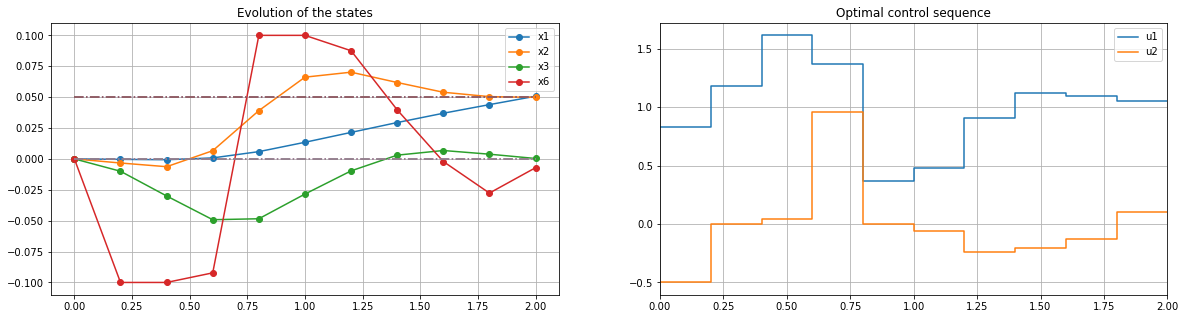

In [16]:
# Get the optimal control sequence 
U_opt = sol_SS['x']

# Simulate the the system under this optimal sequence
X = simu(x0_, sol_SS['x'], eps_)
X = X.full().reshape(-1, nx)
t = np.array([i * dt for i in range(X.shape[0])])


U_opt = U_opt.full().reshape(-1,2)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
[ax[0].plot(t, X[:,i], '-o', label='x'+str(i+1)) for i in [0,1,2,5]];
[ax[0].plot(t, np.ones(len(t))*xd_[i], '-.') for i in [0,1,2,5]];
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Evolution of the states');
#----
U_opt_ = np.array(U_opt)
U_opt_ = np.array([U_opt[0]]+list(U_opt_))
[ax[1].step(t, U_opt_[:,i], label='u'+str(i+1)) for i in range(2)];
ax[1].grid(True)
ax[1].set_title('Optimal control sequence');
ax[1].set_xlim([t.min(), t.max()]);
ax[1].legend();

## The multiple-shooting version<a class="anchor" id="MS-PVTOL"></a> 

Recall that the only difference between the Single-Shooting **(SS)** and the Mutiple-Shooting **(MS)** formulaton lies in the **definition of the decision variable**. More precisely:

- In the SS formulation, the decision variable is the sequence of control $U\in \mathbb R^{N\cdot n_u}$ the sequence $X\in \mathbb R^{N\cdot n_x}$ of the future states over the prediction horizon is an intermediate variable that results from the application of the sequence of control $U$ starting from the initial state $x_0$

- In the MS formulation, the decision variable is the sequence of both control and state, namely $W=(X,U)$, the link between the input and the state is expressed as equality constraint $x(k+1)=F(x(k), u(k))$ or an inequality constraints of the form 

$$0\le x(k+1)-F(x(k), u(k))\le 0$$



So finally the difference is not so important and the following cell show the construction of the MS formulation by changing the similar cell above which is dedicated to the construction of the SS version. 

#### Formulating the Multiple-Shooting optimization problem

In [28]:
# Definition of the weighting matrices to be used in the definition of the cost function 

qvec = [1e3, 1e2, 1e2, 1, 1, 1]
rvec = [1e-1, 1e-1]
qf = 1e1


# Declaration of the initial state and the desired pair

x0 = MX.sym('x0', nx)
xd = MX.sym('xd', nx)
ud = MX.sym('ud', nu)
eps = MX.sym('eps', 1)

# Define the saturation constraints on the control 
umin = [-1, -2]
umax = [2, 3]

# Define the bound on the derivative of theta

dtheta_dt_max = 0.1

# Declaration of the sequence of control over the prediction horizon 
# the control applied on [k,k+1] will be U[k*nu:(k+1)*nu]

U = MX.sym('U', N * nu)
Umin = np.array([umin] * N).flatten()
Umax = np.array([umax] * N).flatten()

# Declaration of the sequence of states over the prediction horizon 

X = MX.sym('X', N * nx)

In [29]:
# the cost function and state initialization
J = 0 
xk = x0

# The list of constraints and its lower and upper bound

g, lbg, ubg = [], [], []

# simulate SYMBOLICALLY over the prediction horizon
for k in range(N-1):
    
    uk = U[k*nu: (k+1)*nu]
    xk = F(xk, uk, eps)
    
    # Equality constraint of the dynamics at instant k 

    g += [xk-X[k * nx: (k+1) * nx]]
    lbg += [0.0] * nx
    ubg += [0.0] * nx
    
    ex = xk-xd
    eu = uk-ud
    
    # add ex.T (Q * ex) to J 
    for j in range(nx):
        J += qvec[j] * ex[j] * ex[j]
    
    # add eu.T (R * eu) to J 
    for j in range(nu):
        J += rvec[j] * eu[j] * eu[j]
        
    # add the constraint on the derivative of theta 
    
    g += [xk[5]]
    lbg += [-dtheta_dt_max]
    ubg += [+dtheta_dt_max]

In [30]:
# add the terminal penalty on the state 
uk = U[(N-1)*nu:]
xk = F(xk, uk, eps)
# Equality constraint of the dynamics at instant k --

k = N-1
g += [xk-X[k * nx: (k+1) * nx]]
lbg += [0.0] * nx
ubg += [0.0] * nx

ex = xk-xd
eu = uk-ud

# add ex.T (Qf * ex) to J 
for j in range(nx):
    
    J += qf * qvec[j] * ex[j] * ex[j]
    
# Declare the decision variable

w = vertcat(U, X)
wmin = list(Umin.flatten())+[-1e3 for _ in range(N * nx)]
wmax = list(Umax.flatten())+[+1e3 for _ in range(N * nx)]

#### Declaring the Multiple-Shooting optimization problem

In [31]:
# Declaring the Multiple-shooting problem 

prob_MS = {'f':J, 'x':w, 'g':vertcat(*g), 'p':vertcat(x0, xd, ud, eps)}

#### Declaring the Multiple-Shooting solver

In [32]:
# declaring the Multiple-shooting solver 

solver_MS = nlpsol('solver', 'ipopt', prob_MS, {'ipopt':{'max_iter':2000}})

### Solving the multiple-shooting open-loop optimal control problem<a class="anchor" id="solvingMS-PVTOL"></a>

In [33]:
# Define the initial guess w0 and the parameters (x0, xd, ud)

w0 = [0.0] * (N * (nu+nx))
x0_ = np.zeros(nx)
xd_ = np.array([0.05, 0.05, 0, 0, 0, 0])
ud_ = np.array([1,0])
eps_ = 0.04

# call the solver 

t1 = time.time()
sol_MS = solver_MS(x0=w0, lbx=wmin, ubx=wmax, lbg=lbg, ubg=ubg, p=vertcat(x0_,xd_,ud_,eps_))
cpu = time.time()-t1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      610
Number of nonzeros in inequality constraint Jacobian.:       45
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:       60
Total number of inequality constraints...............:        9
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        9
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

#### CPU time

In [34]:
print(f"cpu time for casadi = {cpu} using N={N} and tau={T/N}")
print(f"Final cost value = {sol_MS['f']}")

cpu time for casadi = 0.07811570167541504 using N=10 and tau=0.2
Final cost value = 14.2191


### Extrat the results and plot the solution

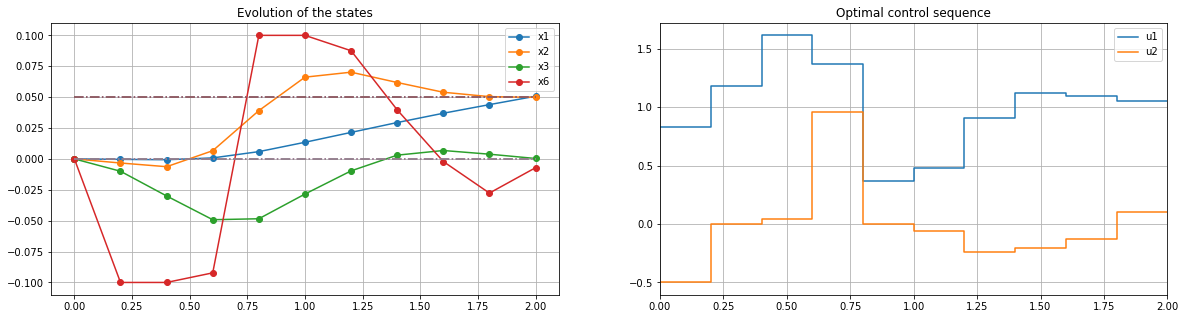

In [35]:
# Get the optimal control sequence 
U_opt = sol_MS['x'][0:N * nu]

# Simulate the the system under this optimal sequence
X = simu(x0_, U_opt, eps_)
X = X.full().reshape(-1, nx)
t = np.array([i * dt for i in range(X.shape[0])])


U_opt = U_opt.full().reshape(-1,2)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
[ax[0].plot(t, X[:,i], '-o', label='x'+str(i+1)) for i in [0,1,2,5]];
[ax[0].plot(t, np.ones(len(t))*xd_[i], '-.') for i in [0,1,2,5]];
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Evolution of the states');
#----
U_opt_ = np.array(U_opt)
U_opt_ = np.array([U_opt[0]]+list(U_opt_))
[ax[1].step(t, U_opt_[:,i], label='u'+str(i+1)) for i in range(2)];
ax[1].grid(True)
ax[1].set_title('Optimal control sequence');
ax[1].set_xlim([t.min(), t.max()]);
ax[1].legend();

### Discussion<a class="anchor" id="discussion"></a>

Note that in the specific example under consideration, the single shooting method leads to better results (The value of the optimal cost is higher than the one with single-shooting for the same definition of the problem's parameters). This is not always the case, especially for high dimensional problems (longer $N$, more states, more controls). It is generally advised to try both in order make the rational choice. 

> **It is interesting to notice that in both case, the solver declares that an optimal solution is reached which should be interpreted as: a local optimal solution is reached that satisfies the necessary condition for local optimality. This simply suggests that the optimization problem is not convex and accepts multiple local minima**

NOTA: Please, observe nevetheless that the computation time for the multiple-shooting version is slightly lower and anyway comparable to the single-shooting case despite the fact that the decision variable is or much higher dimension. 

This experiment suggests that in the case where the problem is strictly convex, multiple-shooting should be prefered to the single-shooting. In the non convex case, it might lead more easily to local minima so experiments have to be conducted off-line to choose the best option.

## Checkpoint-4<a class="anchor" id="checkpoint-4"></a>

Try 100 different initial guess for the single and the multiple shooting version and plot for each, the histograms of the cpu time and the final optimal cost function delivered by the solvers. 

In [25]:
#%load_ext watermark
#print("----")
#%watermark -v -m -p IPython,ipywidgets,casadi,scipy,matplotlib,casadi
#print("----")
#%watermark -u -n -t -z